In [1]:
import matplotlib.pyplot as plt
import json
import os
import numpy as np
from matplotlib.pyplot import figure
import glob

In [6]:
dataset_metadata = { 'yelp': {'n_class': 2, "train_size": 30400, "val_size": 3800, 'metric': 'acc', 'coverage': 0.83}, 
                     'imdb': {'n_class': 2, "train_size": 20000, "val_size": 2500, 'metric': 'acc', 'coverage': 0.88},
                     'trec': {'n_class': 6, "train_size": 4800, "val_size": 500, 'metric': 'acc', 'coverage': 0.95},
                     'youtube': {'n_class': 2,"train_size": 2000, "val_size": 120, 'metric': 'acc', 'coverage': 0.87},
                     'chemprot': {'n_class': 10,"train_size": 12600, "val_size": 1607, 'metric': 'acc', 'coverage': 0.86},
                     'spouse': {"train_size": 22254, "val_size": 2811, 'metric': 'f1_binary', 'coverage': 0.25},
                     'cdr': {"train_size": 8430, "val_size": 920, 'metric': 'f1_binary', 'coverage': 0.907},
                     'amazon31': {'n_class': 31,"train_size": 131781, "val_size": 5805, 'metric': 'acc'},
                      'banking77': {'n_class': 77,"train_size": 9003, "val_size": 1000, 'metric': 'acc'},
                      'massive_lowcard': {"train_size": 11514, "val_size": 2033, 'metric': 'acc'},
                      'dbpedia': {"train_size": 560000, "val_size": 5000, 'metric': 'acc'},
                      'semeval': {'n_class': 9,'train_size': 1749, "val_size": 178, 'metric': 'acc'},
                     'agnews': {'n_class': 4, 'train_size': 96000, "val_size": 12000,'metric': 'acc'},
                     'claude9': {"train_size": 5469, "val_size": 200, 'metric': 'f1_macro'}, 
                     'massive18': {"train_size": 11514, "val_size": 2033, 'metric': 'acc'},
                   }
result_directory = "../results"
datasets = ['amazon31', 'banking77', 'claude9', 'dbpedia', 'massive18','chemprot']
N_RUNS = 5
PERCENT_TRIAL = 1
label_models = ['majority_voting']
end_models = ['bert_roberta_fixed']
# size_to_color = {5: "blue", 50: 'red', 19: 'orange'}
#                   } 
# LM_to_color = { 'majority_voting': 'blue', 
#                 'snorkel': 'orange',
#                 'val_as_train': 'black',
#                 'generative_model': 'green',
#                 'flying_squid': 'red',
#                 'dawid_skene': 'purple'}
# EM_to_color = {'mlp_model' : 'grey',
#                 'bert_classifier_model' : 'yellow'}

pip_to_color = {'val_as_train': 'green',
                'fine_tune_on_val': 'black',
                'fine_tune_on_val_after' : 'blue'}

## Investigation 1: Validation Set Sizes

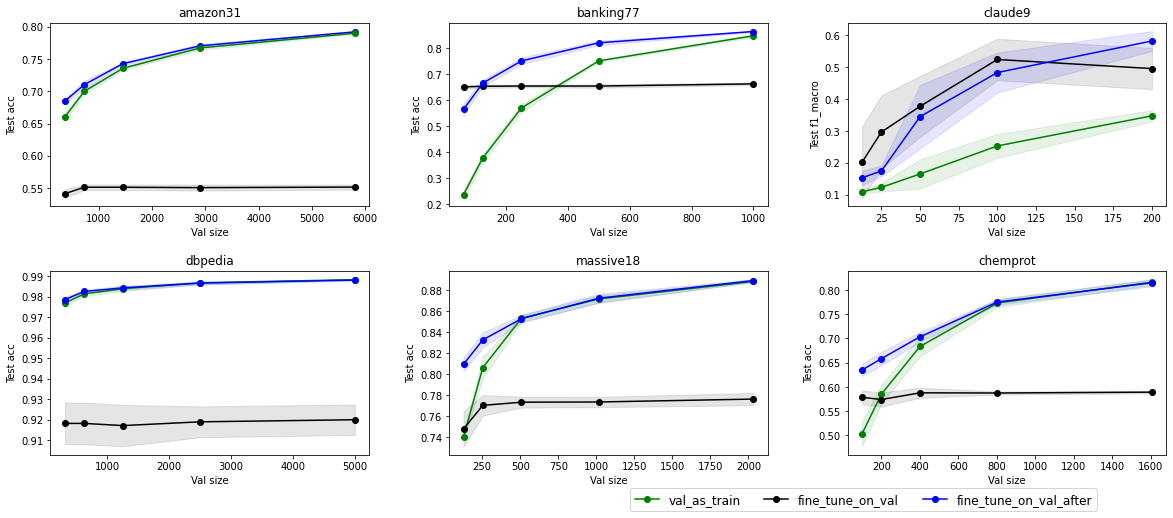

In [7]:
fig, axs = plt.subplots(2, 3, figsize=(20,8))
counter_x = 0
counter_y = 0
draw = []
plot = []
draw = set()
for data in datasets:
    files_per_data = glob.glob(f'{result_directory}/{data}/*.json')
    ax = axs[counter_y, counter_x]
    counter_x += 1
    if counter_x == 3:
        counter_x = 0
        counter_y += 1
    for filepath in files_per_data:
        # finding the newest result
        ind = filepath.find("(")
        if ind != -1:
            n = filepath[ind+1]
            copy = filepath[:ind + 1] + str(int(n) + 1) + filepath[ind+2:]
            if copy in files_per_data:
                continue  
        else:
            copy = filepath[: -5] + "_(2)" +  ".json"
            if copy in files_per_data:
                continue
        with open(filepath) as f:
            file =  (filepath[3:]).split("/")[2].split('.')[0].split("-")
            dataset_name, pip ,LM, EM,  = file[:4]
            if EM !="bert_classifier_model_roberta_fixed":
                continue
            result_dict = json.load(f)
            x = result_dict.keys()
            if len(x) <= 1:
                continue
            if pip == 'fine_tune_on_val' or 'val_as_train':
                # check the metric
                if dataset_metadata[data]['metric'] not in result_dict[list(x)[0]]["em_test"].keys():
                    continue
                x = np.array(list(x)).astype(float) * dataset_metadata[data]['val_size']
                em_test = [result_dict[k]["em_test"] for  k in result_dict]
                em_test_mean, em_test_std = zip(*[list(v.values())[0] for v in em_test])
                em_test_se = np.array(em_test_std) / np.sqrt(N_RUNS)

                ax.plot(x, em_test_mean, label = pip, color = pip_to_color[pip], marker='o')
                ax.fill_between(x, em_test_mean  - 1.96* em_test_se, em_test_mean + 1.96* np.array(em_test_se), alpha=0.1, color =  pip_to_color[pip])
                if pip == 'fine_tune_on_val': 
                    l = pip + "_after"

                    tuned_em_test = [result_dict[k]["tuned_em_test"] for  k in result_dict]
                    tuned_em_test_mean, tuned_em_test_std = zip(*[list(v.values())[0] for v in tuned_em_test])
                    tuned_em_test_se = np.array(tuned_em_test_std) / np.sqrt(N_RUNS)
              
                    ax.plot(x, tuned_em_test_mean, label = l, color = pip_to_color[l], marker='o')
                    ax.fill_between(x, tuned_em_test_mean  - 1.96* tuned_em_test_se, tuned_em_test_mean + 1.96* np.array(tuned_em_test_se), alpha=0.1, color = pip_to_color[l])
    ax.set_title(f"{dataset_name}", fontsize=12)
    ax.set_xlabel("Val size", fontsize=10)
    ax.set_ylabel("Test {}".format(dataset_metadata[data]['metric']), fontsize=10)
    if counter_x == 0 and counter_y == 1:
            ax.legend(ncol=5, bbox_to_anchor=(0.8, -1.5), fontsize = 12)   
plt.subplots_adjust(bottom=0.25, top=1.0, hspace=0.35, wspace=0.25)
plt.savefig("val_size")